<a href="https://colab.research.google.com/github/gigihsantoso/prediksi-saham/blob/main/Deep_Learning_Saham_BRIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Time Series

##Setup

In [48]:
import yfinance as yf
import pathlib
import tensorflow as tf
import zipfile
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import drive, files, data_table
import tensorflow as tf
from datetime import timedelta, date

## Load Data

In [49]:
data = yf.download('BRIS.JK', period='max').astype(int).sort_index(ascending=True)

[*********************100%***********************]  1 of 1 completed


##Exploring

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1065 entries, 2018-05-09 to 2022-08-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Open       1065 non-null   int64
 1   High       1065 non-null   int64
 2   Low        1065 non-null   int64
 3   Close      1065 non-null   int64
 4   Adj Close  1065 non-null   int64
 5   Volume     1065 non-null   int64
dtypes: int64(6)
memory usage: 58.2 KB


In [51]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-05-09,600,630,520,545,537,275187300
2018-05-11,550,660,550,620,610,285278000
2018-05-14,620,650,600,600,591,124691400
2018-05-15,600,600,600,600,591,0
2018-05-16,600,600,600,600,591,0


In [52]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1065.000000,1065.000000,1065.000000,1065.000000,1065.000000,1.065000e+03
mean,1110.184038,1138.235681,1085.912676,1107.987793,1094.167136,5.647402e+07
std,811.180854,837.331202,788.121353,809.191259,799.588177,1.218612e+08
min,136.000000,155.000000,135.000000,135.000000,133.000000,0.000000e+00
25%,505.000000,510.000000,500.000000,505.000000,498.000000,5.363600e+06
50%,605.000000,610.000000,590.000000,600.000000,591.000000,1.282110e+07
75%,1745.000000,1775.000000,1720.000000,1740.000000,1718.000000,4.510970e+07
max,3800.000000,3980.000000,3710.000000,3770.000000,3722.000000,1.318652e+09


##Helper

In [53]:
def dataframe_split(data, test= 7):
  part_  = data.iloc[:int(test * -1)]
  rest_part_ = data.drop(part_.index)
  return (part_, rest_part_)

In [54]:
def df_to_tsdf(data, input_width, label_width, shift, batch_size):
    series = tf.expand_dims(data, axis=-1)
    fts = tf.data.Dataset.from_tensor_slices(series)
    window = fts.window(input_width + label_width + 1, shift=shift, drop_remainder=True)
    flat = window.flat_map(lambda w: w.batch(input_width + label_width + 1))
    map = flat.map(lambda w: (w[:input_width], w[label_width * -1:]))
    batch = map.batch(batch_size, drop_remainder=True)
    ds = batch.prefetch(tf.data.AUTOTUNE)
    return ds

In [55]:
def df_to_predict(model, data, windows, shift):
  series = tf.expand_dims(data, axis=-1)
  fts = tf.data.Dataset.from_tensor_slices(series)
  window = fts.window(windows, shift=shift, drop_remainder=True)
  flat = window.flat_map(lambda w: w.batch(windows))
  map = flat.map(lambda w: (w[:windows]))
  batch = map.batch(1)
  ds = batch.prefetch(tf.data.AUTOTUNE)
  predict = model.predict(ds)
  return predict.flatten()

In [56]:
def plot_metric(x, y, history, metric):
  fig, ax = plt.subplots(x, y, figsize=(15,10))
  epochs = range(len(history.history[metric[0]]))
  for metric, ax in zip(metric, ax.flatten()):
    ax.plot(epochs, history.history[metric], 'r', label='train')
    # ax.plot(epochs, history.history['val_'+metric], 'b', ls="--", label='val')
    ax.set_ylabel(metric)
    ax.set_xlabel('epoch')
    ax.legend()  
  plt.show()

##Preprocessing

In [57]:
df_model = data.copy()
df_model['Scaler'] =  (df_model.loc[:, 'Close']-df_model.loc[:, 'Close'].min())/(df_model.loc[:, 'Close'].max()-df_model.loc[:, 'Close'].min())

In [58]:
train_m, test_m = dataframe_split(df_model, test=210)

In [59]:
data_m = train_m['Scaler']
input_width = 15
label_width = 15
shift = 15
batch_size = 5
ds = df_to_tsdf(data_m, input_width, label_width, shift, batch_size)

##Model

In [60]:
#Buatlah model dengan input layer disarankan menggunakan LSTM LSTM dan output layer 1 
model = tf.keras.models.Sequential([
    #Code Here
    tf.keras.layers.LSTM(256, return_sequences=False),
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(15),
    # tf.keras.layers.Reshape([6, 1])
])
Metric = [
    tf.keras.metrics.MeanAbsoluteError(name='mean_absolute_error'),
    tf.keras.metrics.RootMeanSquaredError(name='root_mean_squared_error')
]
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[Metric])
history = model.fit(ds, epochs =100)

Epoch 1/100
11/11 [==============================] - 2s 7ms/step - loss: 0.1312 - mean_absolute_error: 0.1312 - root_mean_squared_error: 0.1927
Epoch 2/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0606 - mean_absolute_error: 0.0606 - root_mean_squared_error: 0.0864
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0520 - mean_absolute_error: 0.0520 - root_mean_squared_error: 0.0871
Epoch 4/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0567 - mean_absolute_error: 0.0567 - root_mean_squared_error: 0.0930
Epoch 5/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0500 - mean_absolute_error: 0.0500 - root_mean_squared_error: 0.0836
Epoch 6/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0469 - mean_absolute_error: 0.0469 - root_mean_squared_error: 0.0767
Epoch 7/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0509 - mean_absolute_error: 0.0509 - root_mean_squared_error:

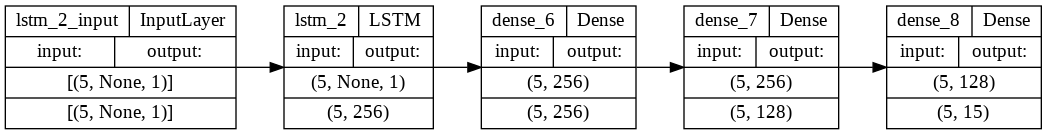

In [61]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

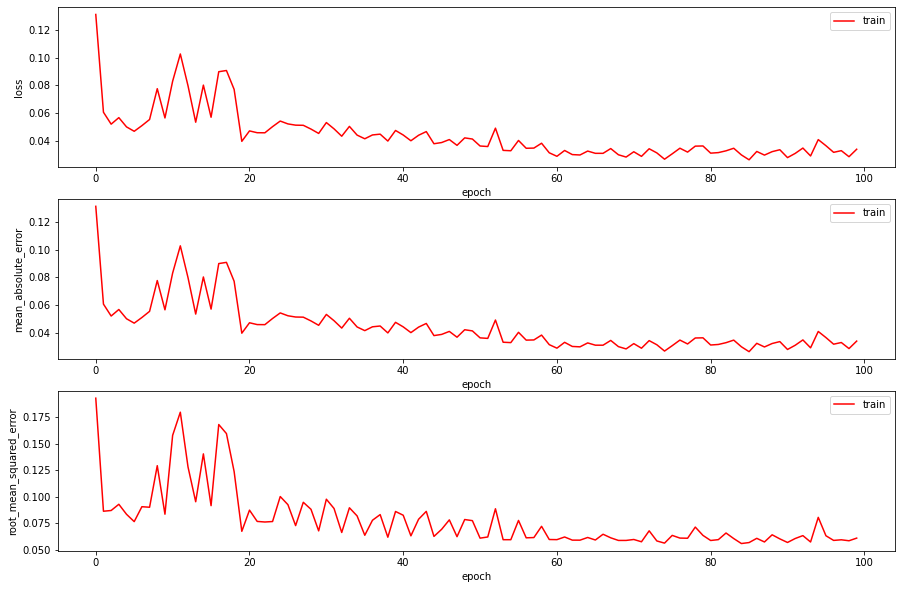

In [62]:
metric = ['loss', 'mean_absolute_error', 'root_mean_squared_error',]
plot_metric(3,1, history, metric)

##Simulation

In [63]:
test_m_x = test_m.reset_index()

In [64]:
data_m_s = test_m['Scaler']
windows_s = 15
shift_s = 15
predict = df_to_predict(model, data_m_s, windows_s, shift_s)
date_predict = pd.DataFrame(pd.bdate_range(start=date.today()+timedelta(days=1), periods=16), columns=['Date'])
res_simulation = pd.concat([test_m_x[['Date']].iloc[input_width + 1:], date_predict], ignore_index=True)
for label, row in res_simulation.iterrows():
    res_simulation.loc[label, ['Scaler']] = 0
res_simulation['Scaler'] = predict
res_simulation = res_simulation.set_index("Date")

In [65]:
len(predict)

210

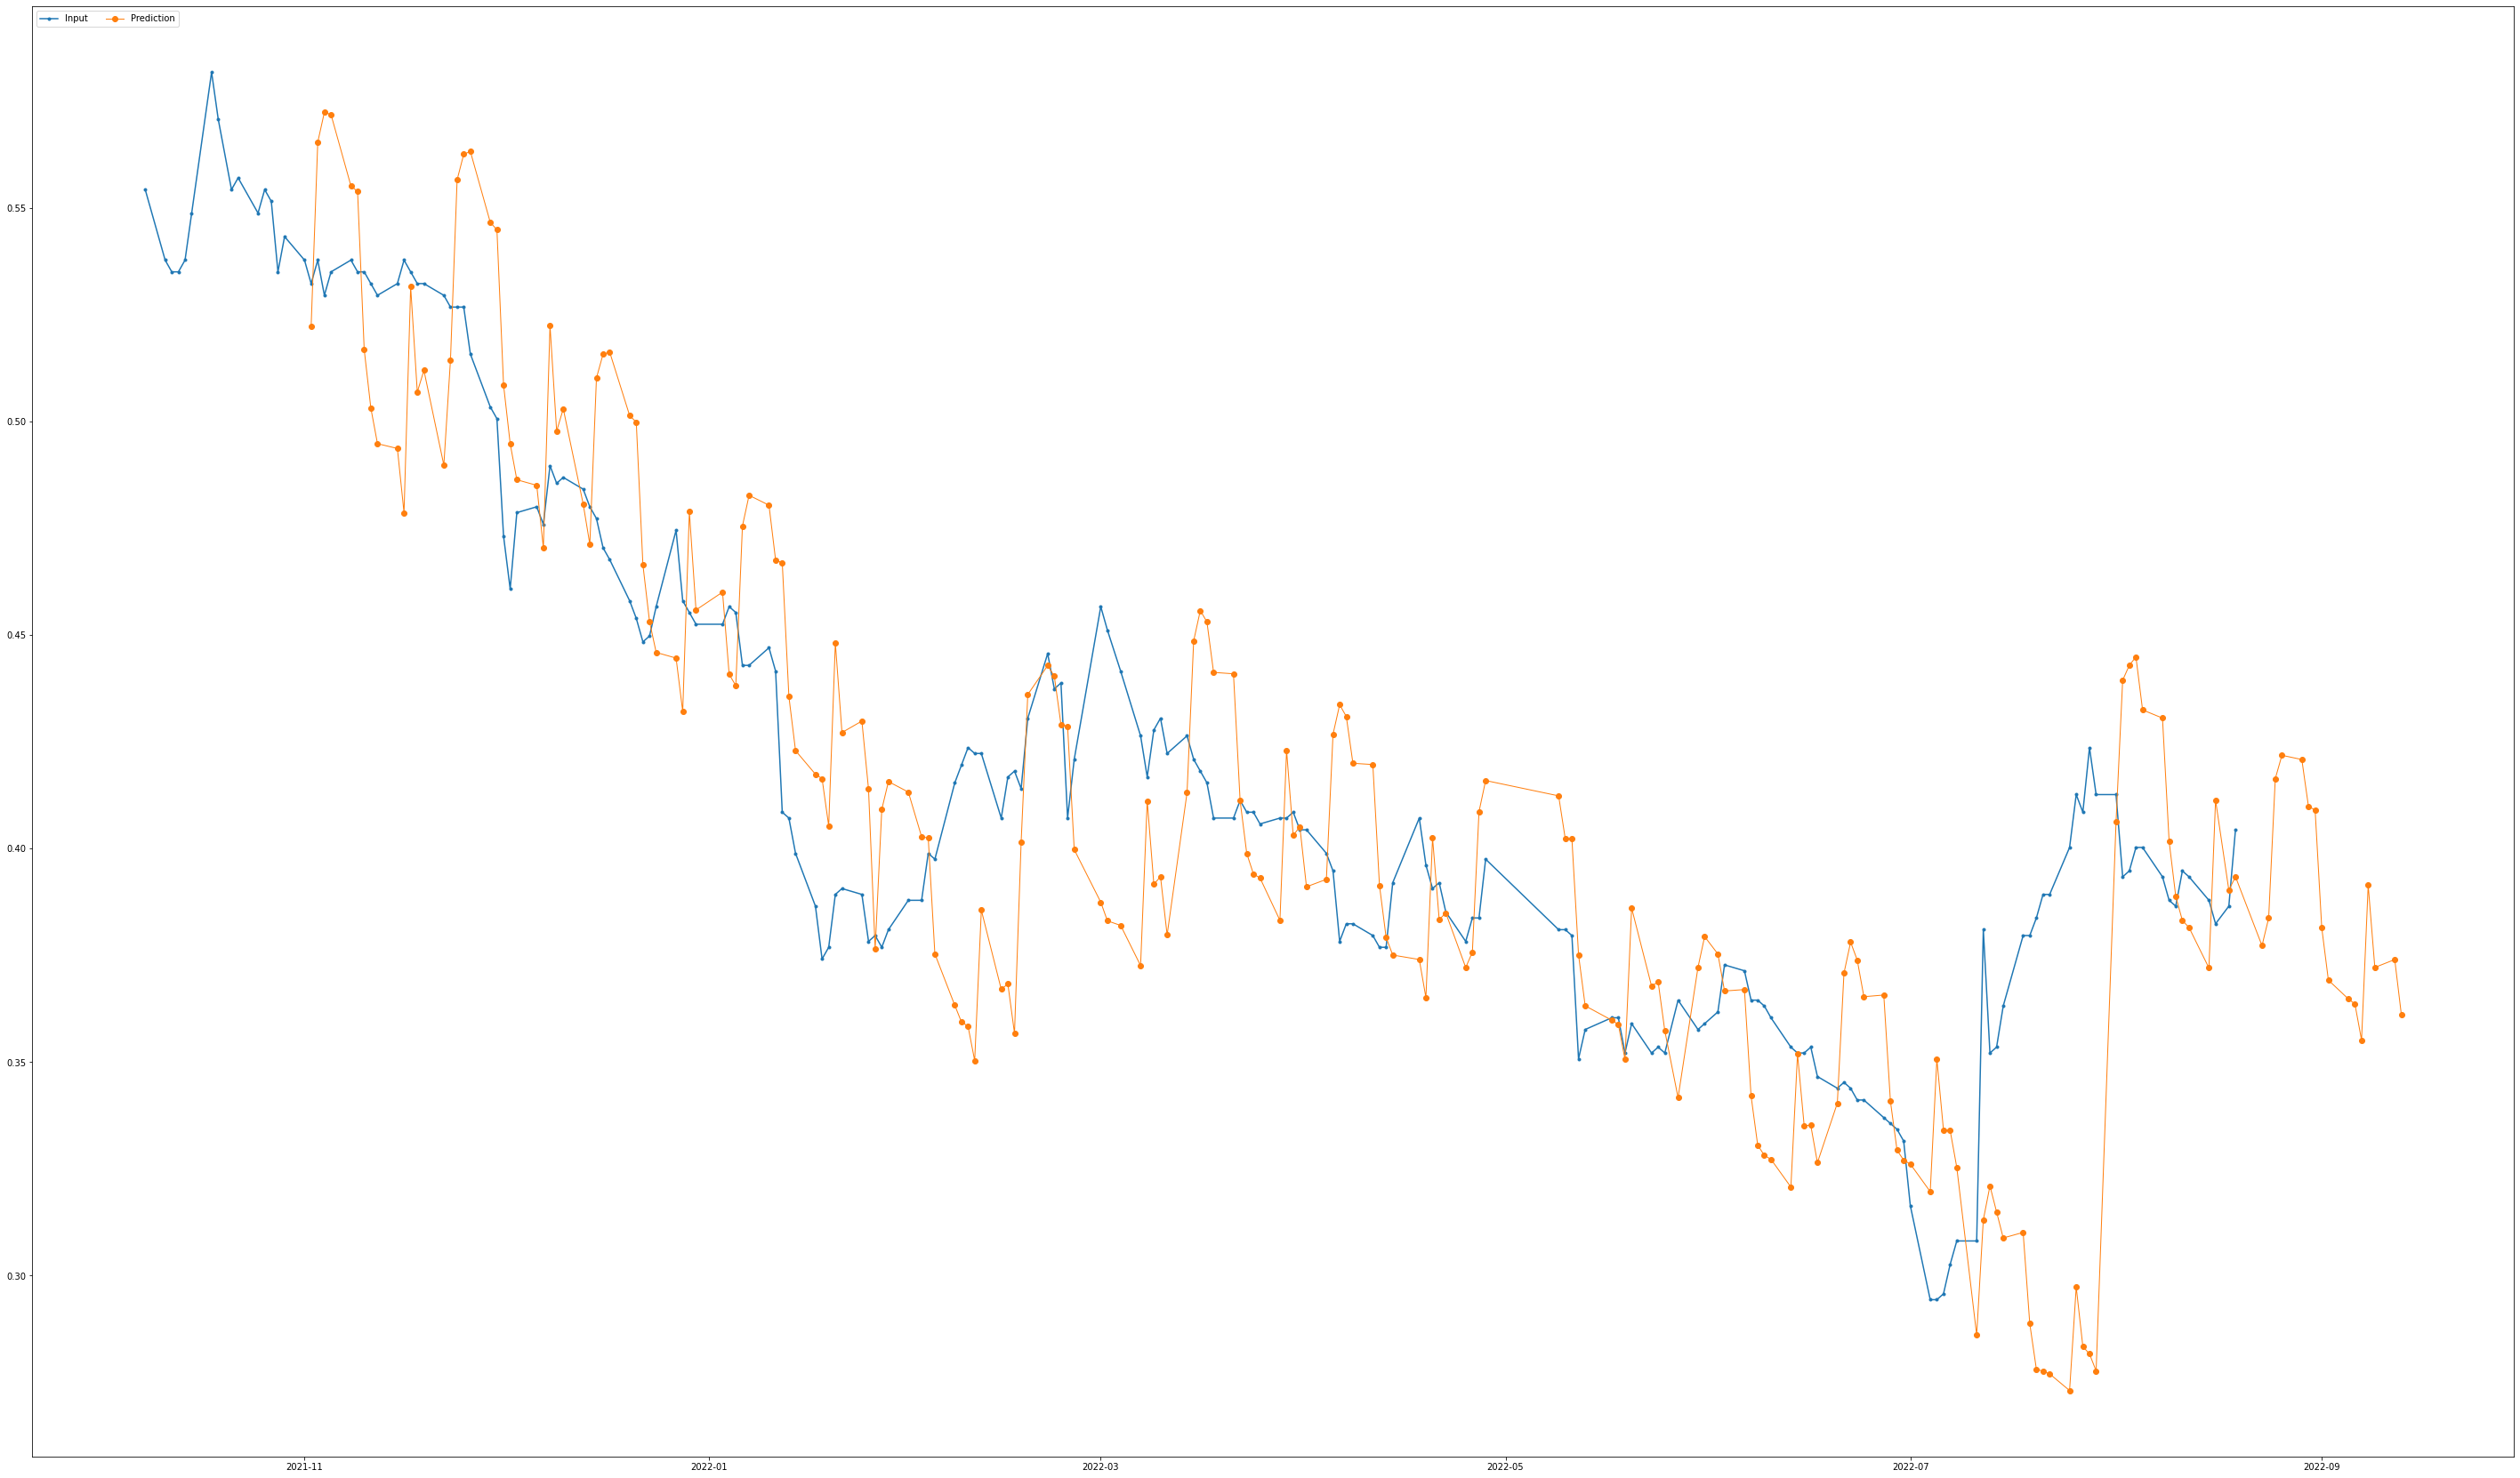

In [66]:
fig, ax = plt.subplots(figsize=(50,30))
ax.plot(test_m['Scaler'], marker=".", linewidth=1.5)
ax.plot(res_simulation, marker="o", linewidth=1)
ax.legend(["Input", 'Prediction', 'Prediction 2'], loc='upper left', ncol=3, )
plt.show()

##Save Model

In [67]:
# MODEL_DIR = "models/model"
# version = 1
# export_path = os.path.join(MODEL_DIR, str(version))
# tf.keras.models.save_model(
#     model,
#     export_path
# )

## Download Save Model

In [68]:
# !zip -r /content/model_bris.zip /content/models

In [69]:
# files.download('/content/model_bris.zip')